# Continuous Sequential Importance Resampling for Stochastic Volatility Models

### Hans-Peter Hollwirth, Robert T. Lange and Davide Viviano

### Introduction

In this notebook we introduce the reader to basic stochastic volatility models and we discuss their estimation through Continuous Sequential Importance Resampling. The code has been developed in R and C. We use a synthetic dataset to discuss the implementation and the performance of CSIR for stochastic volatility models estimation. 

### A first Stochastic Volatility Model

Let $y_t$ being the stock return at time $t$ and $\sigma_t$ being its standard deviation. Consider the following discrete time Stochastic Volatility Model: 

$$
\begin{aligned}
&\text{log}(\sigma_t^2) = \phi_0 + \phi_1 \text{log}(\sigma_{t-1}^2) + \eta_t \\
&y_t = \sigma_t z_t
\end{aligned}
$$
with $z_t \sim \mathcal{N}(0,1)$ and $\eta_t \sim \mathcal{N}(0, \tau^2)$, with $\tau > 0$ and $|\phi_1| < 1$ in order to ensure that the volatility follows a stationary process. 
Intuitively, the volatility process is modeled as a latent process where $\text{log}(\sigma_t^2)$ follows an AR(1) process. In the next chunk we simulate the process. Over the notebook we will keep working with these simulated data. For sake of brevity we define $\alpha_t = \text{log}(\sigma_t^2)$ and $\theta = (\phi_0, \phi_1, \tau)$ being the vector of parameters.

In [1]:
# house cleaning
rm(list=ls())
save.plots <- FALSE
set.seed(1234, kind = NULL, normal.kind = NULL)

library(fanplot)

In [3]:
## We simulate the data: 
## we set phi_0 = 0.05, phi = 0.98, tau = 0.02
T <- 1000; const <- 0.05; phi <- 0.98; tau2 <- 0.02
theta <- c(const, phi, tau2)

## Function to simulate the data (available in the source code sv_sim.R)

#Input 1: theta - parameter vector (bias, AR coefficient, error variance) 
#Input 2: T     - size of time series
#Output:  retDF - simulated returns (y) and volatility (alpha)

sv_sim <- function(theta, T) {

    const <- theta[1]              # intercept/constant/bias
    phi <- theta[2]                # autocorrelation coefficient phi
    tau2 <- theta[3]               # normal error with tau2 variance
    alpha <- rep(0,T)              # placeholder volatility
    y <- rep(0,T)                  # placeholder returns
    eta <- rnorm(T, 0, sqrt(tau2)) # error of AR(1) volatility model
    z <- rnorm(T, 0, 1)            # multiplicative term return model
    alpha[1] <- const              # no autocorrelated observation in starting period

    y[1] <- z[1] * exp(alpha[1]/2)
    for (t in 2:T) {
        alpha[t] <- const + phi*(alpha[t-1]) + eta[t]
        y[t] <- z[t]*exp(alpha[t]/2)
    }

    retDF = data.frame(alpha, y)
    return(retDF)
}


# simulate time series
sim_df <- sv_sim(theta, T)
y <- sim_df$y
alpha <- sim_df$alpha


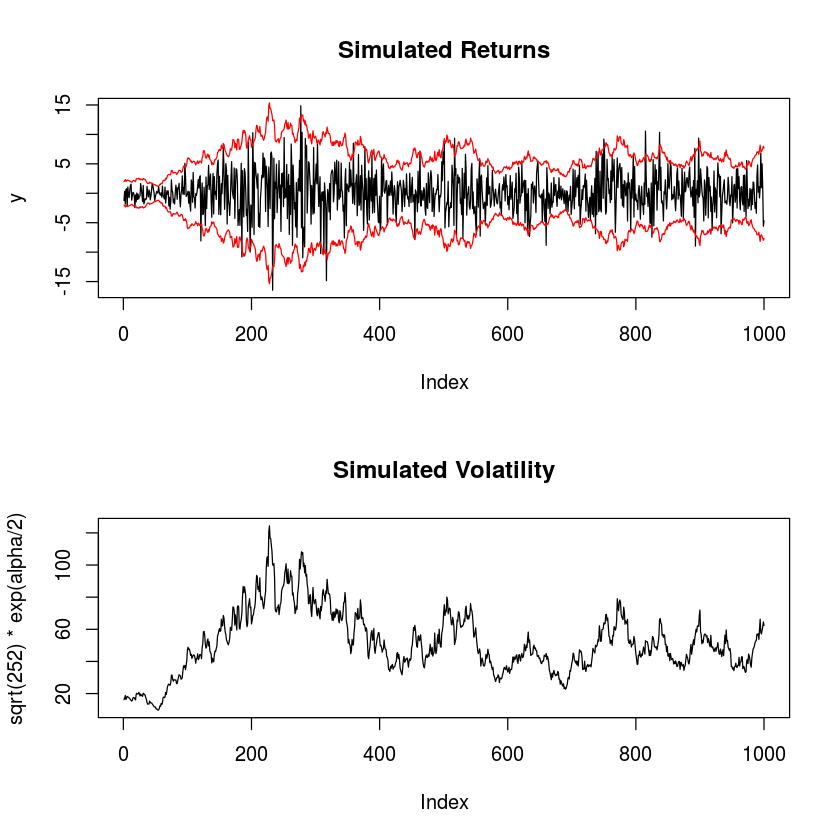

In [4]:
# plot time series with 95% confidence interval
if(save.plots) pdf("../images/ts_returns.pdf")
par(mfrow=c(2,1))
plot(y, type="l", main ="Simulated Returns")
lines( 1.96 * exp(alpha/2), col= "red")
lines(-1.96 * exp(alpha/2), col= "red")
plot(sqrt(252) * exp(alpha/2), type='l', main="Simulated Volatility")
if(save.plots) dev.off()



### Hidden Markov Model: Definitions

The model shown above belong to the more general class of Hidden Markov Models. Let $h(\alpha_t | \alpha_{t-1}; \theta)$ be the transition density and $g(y_t | \alpha_t; \theta)$ the measurement density. Then in this case the transition and measurement densities are both Gaussians, with $\alpha_t | \alpha_{t-1}, \theta \sim \mathcal{N}(\phi_0 + \phi_1 \alpha_{t-1}, \tau^2)$ and $y_t | \alpha_t;  \theta \sim \mathcal{N}(0,\exp(\alpha_t))$.  

Let $\mathcal{F}_t$ being the filtration at time $t$. The prediction density is defined as $P(\alpha_t; \mathcal{F}_{t-1}, \theta)$ and the filtering density is $P(\alpha_t | \mathcal{F}_t; \theta)$. Therefore the prediction density can be rewritten as 

$$
P(\alpha_t | \mathcal{F}_{t-1}; \theta) = \int h(\alpha_t | \alpha_{t-1}; \theta) P(\alpha_{t-1} | \mathcal{F}_{t-1}; \theta) d \alpha_{t-1} 
$$
and the filtering density as 
$$
P(\alpha_t | \mathcal{I}_t; \theta) \propto g(y_t | \alpha_t; \theta) P(\alpha_t | \mathcal{F}_{t-1}; \theta)
$$

We can factorize the log-likelihood as 
$$
\text{log}(L_n(\theta)) = \sum_{t=1}^n \text{log}(P(y_t | \mathcal{F}_{t-1}; \theta))
$$
with $P(y_t | \mathcal{F}_{t-1}; \theta) = \int g(y_t |  \alpha_t ; \theta) P(\alpha_t | \mathcal{F}_{t-1}; \theta) d \alpha_t$.

### Sequential Monte Carlo

For the estimation we use sequential Monte Carlo, by generating $P$ random draws, called "particles" in order to approximate the prediction and filtering density. Whereas there are many variants, we only discuss (Continuous) Sequential Importance Resampling(SIR). 

SIR has two steps, prediction and filtering step. 

The **prediction step** is the following: 
- Input: particles $\alpha_{t-1}^{(i)}$ from $P(\alpha_{t-1} | \mathcal{F}_{t-1}; \theta)$; 
- Output: for each particle $\alpha_{t-1}^{(i)}$  obtain a new prediction particle by propagating the system by using the transition density, that is $\alpha_t^{(i)} \sim h(\alpha_t^{(i)} | \alpha_{t-1}^{(i)}; \theta)$, for $i = 1,...,P$. 

The **filtering step** is the following: 

- Input: Realization of the $y_t$ process and particles $\alpha_{t}^{(i)}$ draws in the prediction step; 
- Algorithm: 
   - Compute the importance weights for each particle $w_t^{(i)} = \frac{g(y_t | \alpha_t^{(i)}; \theta)}{\sum_{i=1}^P     g(y_t | \alpha_t^{(i)}; \theta)}$;
   - Sample the filtering particles for $\alpha_t^{(j)}|\mathcal{F}_{t-1}$ for $j = 1, ..., P$ via multinomial sampling by picking a particle $\alpha_t^{(i)}|\mathcal{F}_{t-1}$ with probability $w_t^{(i)}$ (in the code we use uniform rejection sampling);
   - Output: filtered particles. 

In our case the prediction step consists in drawing $\alpha_t^{(i)} \sim \mathcal{N}(\phi_0 + \phi_1 \alpha_{t-1}, \tau^2)$, for $i = 1,...,P$ and in the filtering step we have $g(y_t | \alpha_t^{(i)}; \theta) = \mathcal{N}(0, \exp(\alpha_t^{(i)}))$.  

**Notice** that Sequential Monte Carlo suffers of propagation of the approximation error and it requires that the number of particles increases with the number of observations. 

To approximate the likelihood we know that 
$$
P(y_t | \mathcal{F}_{t-1}; \theta) = \int g(y_t | \alpha_t; \theta)P(\alpha_t| \mathcal{F}_{t-1}; \theta) d \alpha_t
$$
Let the **simulated** likelihood contribution be
$$
\hat{P}(y_t | \mathcal{F}_{t-1}; \theta) = \frac{1}{P} \sum_{i=1}^P g(y_t | \alpha_t^{(i)}; \theta)
$$
And let the simulated MLE be
$$
\hat{\theta}^{SMLE} = \text{argmax}_{\theta} \sum_t \frac{1}{P} \sum_{i=1}^P g(y_t | \alpha_t^{(i)}; \theta)
$$



### Filtering step with Continuous Sequential Importance Resampling: the algorithm 

**Continuous Sequential Importance Resampling**(CSIR) is a variant of SIR and it provides a continuous version of filtered particles. The main advantage of the method is that it ensures that the simulated likelihood is "smooth" with respect to the vector of parameters $\theta$ in order to be able to use gradient based optimization methods for its optimization.

The algorithm for the filtering step using CSIR is the following:

- Input: 

     - Sorted uniformly random sampled vector (rejection sampling) with entries $u^{(j)}$;
     - Normal PDF evaluated at $y_t$ for each particle $\alpha_t^{(i)}$ defined as $W_t^{(i)}$;
     - Sorted draws from predictive density $\alpha_t^{(i)}$. 

- Algorithm: for each t
     
     - Set $s = 0$, $j = 1$; 
     - For i in $1:P$: 
           
          - s = s + $W_t^{(i)}$
          - while ($u^{(j)}$ < s AND $u^{(j)}$ < s + $W_t^{(i+1)}$)
                 
             - alpha_up[t,j] =  $\alpha_t^{(i)}$ + (($\alpha_t^{(i+1)}$-$\alpha_t^{(i)}$)/($W_t^{(i+1)}$)) * ($u^{(j)}$-s)
             - if (j < P): j = j +1
- Output: alpha_up (filtered particles)

Theoretical properties and a more comprehensive description of the algorithm can be found in the following paper: Malik, Sheheryar, and Michael K. Pitt. "Particle filters for continuous likelihood evaluation and maximization." Journal of Econometrics 165.2 (2011): 190-209. 


### The code

Below we generate the particle set and we approximate the filtering and prediction densities using SIR. In the first plot we show the prediction density mean and its $95\%$ and $5\%$ quantile. In the same plot we also plot the true value of the volatility. In the second plot we plot the heat map of the filtering density. The black line is the true volatility. 

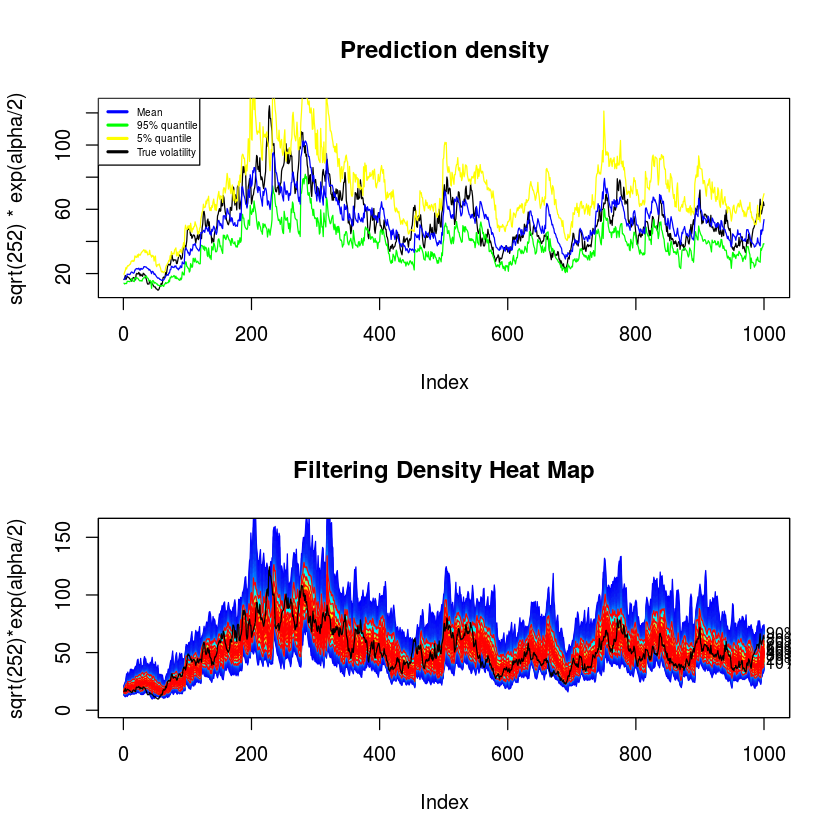

In [5]:
#  --> (Original) Sequential Importance Sampling Algorithm: filtering step

# Input 1: alpha_pr - predictive density
# Input 2: alpha_wt - normal pdf evaluated at y[t]
# Input 3: u        - sorted uniformly random sampled vector (rejection sampling)
# Output:  alpha_up - particle filtered

sir <- function(alpha_pr, alpha_wt, u) {

    P <- length(alpha_pr)
    alpha_up <- rep(0,P)

    # sorting and weighting slows down
    alpha_wt <- alpha_wt/sum(alpha_wt)
    alpha_sort <- cbind(seq(1,P,1),alpha_pr)
    alpha_pr_idx <- alpha_sort[order(alpha_sort[,2]),]
    alpha_pr <- alpha_pr_idx[,2]
    alpha_idx <- alpha_pr_idx[,1]
    alpha_wt <- alpha_wt[alpha_idx]
    alpha_cwt <- c(0, cumsum(alpha_wt))

    j <- 1
    for (i in 1:P){
        while((alpha_cwt[i] < u[j]) && (u[j] <= alpha_cwt[i+1])){
            alpha_up[j] <- alpha_pr[i]
            if (j < P){
                j <- j+1
            }
        else break
        }
    }
    return(alpha_up)
}

# ----------------------------------------------------------------------
# Setup particle filtering
# ----------------------------------------------------------------------
P <- 200 # set number of particles
alpha_up <- rnorm(P,0,0.1)
alpha_pr <- rep(0,P)
alpha_wt <- rep(1,P)/P

alpha_up_mat <- matrix(rep(0, T*3),T)
alpha_pr_mat <- matrix(rep(0, T*3),T)
alpha_pr_are <- matrix(rep(0, T*20),T)


# generate a particle set of P random draws from an approximation
# of the prediction and filtering distribution for every time series point
for (t in 1:T){
    # prediction step
    alpha_pr <- const + phi * alpha_up  + rnorm(P,0,sqrt(tau2))
    # update/filtering step (normal density)
    alpha_wt <- dnorm(y[t]*rep(1,P), mean=0 , sd = exp(alpha_pr/2))
    alpha_up <- sir(alpha_pr=alpha_pr,alpha_wt=alpha_wt, u=sort(runif(P,0,1)))

    alpha_up_mat[t,2] <- mean(alpha_up)
    alpha_up_mat[t,1] <- quantile(alpha_up,0.05)
    alpha_up_mat[t,3] <- quantile(alpha_up,0.95)

    alpha_pr_mat[t,2] <- mean(alpha_pr)
    alpha_pr_mat[t,1] <- quantile(alpha_pr,0.05)
    alpha_pr_mat[t,3] <- quantile( alpha_pr,0.95)
    alpha_pr_are[t,] <- quantile(alpha_pr, seq(0,1,1/(ncol(alpha_pr_are)-1)))
}

# plot prediction density
if(save.plots) pdf("../images/prediction_density.pdf")
par(mfrow=c(2,1))
plot(sqrt(252) * exp(alpha/2), type='l', main="Prediction density")
lines(sqrt(252) * exp(alpha_up_mat[,1]/2), col='green')
lines(sqrt(252) * exp(alpha_up_mat[,2]/2), col='blue')
lines(sqrt(252) * exp(alpha_up_mat[,3]/2), col='yellow')
legend("topleft", legend=c("Mean", "95% quantile", "5% quantile", "True volatility"),        
           cex=0.5, lwd=c(2.5,2.5),col=c("blue","green", "yellow", "black"))
## filtering density heat map
    
heat <- matrix(rep(1,T*20), T, 20)
for (i in 1:20) {
    heat[,i] <- sqrt(252)*exp(alpha_pr_are[,21-i]/2) 
}
jet.colors <- colorRampPalette(c("red", "#FF7F00", "yellow","#7FFF7F", "cyan", "#007FFF", "blue"), 
                               bias=1, space="rgb", interpolate="spline")

plot(NULL, xlim = c(1, T), ylim = c(0, 160), main="Filtering Density Heat Map", ylab="sqrt(252)*exp(alpha/2)", xlab="Index")
fan(data = t(heat), fan.col = jet.colors)
lines( sqrt(252)*exp(alpha/2) ,  col="black")
    
if(save.plots) dev.off()



In the next chunk we provide both an R and C version of CSIR. The R version is given only for the purpose of readability of the code. 

In [6]:
### Continuous Sequential Importance Resampling : filtering step

# Input 1: alpha_pr - predictive density
# Input 2: alpha_wt - normal pdf evaluated at y[t]
# Input 3: u        - sorted uniformly random sampled vector (rejection sampling)
# Output:  alpha_up - particle filtered (continuous version)

# R version (slow performance)
csir <- function(alpha_pr, alpha_wt, u) {
    P <- length(alpha_pr)

    alpha_up <- rep(0,P)
    
    # sorting and weighting slows down
    alpha_wt <- alpha_wt/sum(alpha_wt)
    alpha_sort <- cbind(seq(1,P,1),alpha_pr)
    alpha_pr_idx <- alpha_sort[order(alpha_sort[,2]),]
    alpha_pr <- alpha_pr_idx[,2]
    alpha_idx <- alpha_pr_idx[,1]
    alpha_wt <- alpha_wt[alpha_idx]
    alpha_cwt <- c(0, cumsum(alpha_wt))
    alpha_pr  <- c(alpha_pr[1], alpha_pr)

    j <- 1
    for (i in 1:P){
        while((alpha_cwt[i] < u[j]) & (u[j] <= alpha_cwt[i+1])){
            alpha_up[j] <- alpha_pr[i] + ((alpha_pr[i+1]-alpha_pr[i])/(alpha_cwt[i+1]-alpha_cwt[i])) * (u[j]-alpha_cwt[i])
            if (j < P){
                j <- j+1
            }
            else break
        }
    }
    return(alpha_up)
}

# wrapper for C version (increased performance: 5 times faster), default version
dyn.load("csir.so") 
csir.c <- function(alpha_pr, alpha_wt, u) {
    P <- length(alpha_pr)
    alpha_up <- rep(0,P)
    results <- .C("csir", alpha_up=as.double(alpha_up), 
                          alpha_pr=as.double(alpha_pr), 
                          alpha_wt=as.double(alpha_wt), 
                          u=as.double(u), 
                          len=as.integer(P))
    return (results$alpha_up) 
}


Below we provide the function for the estimation of the simulated log-likelihood

In [7]:
sv_loglik <- function(theta, y, eta_sim, u_sim, alpha_up, alpha_wt, c_version=T) {
    
    T <- length(y)
    P <- length(alpha_up)
    const <- theta[1]
    phi <- theta[2]
    tau2 <- theta[3]
    
    alpha_up_pr <- matrix(0, nrow=T, ncol=4)
    
    loglik <- 0 

    for (t in 1:T) {
        alpha_pr <- const + phi*alpha_up + sqrt(tau2)*eta_sim[,t]
        lik <- dnorm( y[t]*rep(1,P) , rep(0,P) , exp(alpha_pr/2))
        ## Deal with error in the optimization
        log_mean_lik <- tryCatch(log(mean(lik)), error=function(e)(-Inf))
       
            if (log_mean_lik == -Inf) {
            print(paste('problem at ',as.character(t),as.character(theta)))
            loglik <- Inf
            alpha_up_pr <- NA
            break
        } else {
            loglik <- loglik - log_mean_lik
            # update
            alpha_wt <- lik
            if(c_version){alpha_up <- csir.c(alpha_pr, alpha_wt, u_sim[,t])} else{
              alpha_up <- csir(alpha_pr, alpha_wt, u_sim[,t])
            }
    
            # quantiles
            alpha_up_pr[t,1] <- mean( alpha_up )
            alpha_up_pr[t,2] <- mean( alpha_pr )
            alpha_up_pr[t,c(3,4)] <- quantile( alpha_pr ,c(0.05,0.95))
        } 
    }
  
    loglik <- loglik/T
    return(list(loglik = loglik, alpha_up_pr = alpha_up_pr))
}
 


We now provide the code for the maximization of the log-likelihood and estimation of the parameter $\theta$. For computing the standard errors we use the diagonal entries of the negative of the inverse of the Hessian matrix of the log-likelihood evaluated at the MLE. If standard errors are not needed, we recommed to set in the sv_fit function mode=2 , since it does not require the evaluation of the Hessian and it leads to faster approximation. 

In [25]:
library(nloptr)

## Input:
## y: Vector of returns
## theta: intialization for the vector of parameters
## P: Number of particles
## mode: mode=1 compute se with slower optimization method

sv_fit <- function(y, theta, P, mode=1) {
    T <- length(y)
  
    alpha_up_0 <- rnorm(P, 0,1)
    alpha_wt_0 <- rep(1/P,P)
    eta_sim <- rnorm(P*T, 0,1)
    eta_sim <- matrix(eta_sim, nrow=P, ncol=T)
    u_sim <- runif(P*T, 0,1)
    u_sim <- matrix(u_sim, P, T)
  
    for (t in c(1:T)) {u_sim[,t] <- sort( u_sim[,t] )}
  
    if(mode==1 | mode==2) {
        # set optimization parameters
        lb <- rep(0,length(theta)) + 0.001;
        ub <- rep(1,length(theta)) - 2*exp(-10);
        obj <- function(x){ return( sv_loglik(x, y, eta_sim, u_sim, alpha_up_0, alpha_wt_0)$loglik ) } 
        
        # run box-constrained optimization
        if (mode==1) {
            print('estimating...') 
            param <- optim( theta, obj, method='L-BFGS-B', lower=lb, upper=ub, hessian=TRUE )
            theta_se <- sqrt(abs(diag(solve(param$hessian))))
        } else {
            print('estimating (without standard errors)...') 
            param <- nlminb( theta, obj, lower=lb, upper=ub )
            theta_se <- c()
        }
        theta_mle <- param$par
        print('... done!') 
    
    } else {
        theta_mle <- c()
        theta_se <- c()
    }
  
    # compute log-liklihood (quantiles) of MLE parameters
    ll <- sv_loglik(theta_mle, y, eta_sim, u_sim, alpha_up_0, alpha_wt_0)
    
    return(list(loglik      = - ll$loglik, 
                theta_mle   = theta_mle, 
                theta_se    = theta_se,
                alpha_up_pr = ll$alpha_up_pr))
}


We can now move to the estimation of the parameters $\theta$. Estimation is done using the function in C. In case needed, the function in R can be implemented by setting in the sv_loglik function c_version = F. We initialize the parameters at $0.5$ for each parameter. Any other guesses strictly positive and lower than one would work. 

In [26]:
values <- sv_fit(y, c(0.5,0.5,0.5), P, 1)


[1] "estimating..."
[1] "... done!"


In [27]:
## Display results
matrix <- cbind(theta,values$theta_mle
,values$theta_se)
colnames(matrix) <- c("True theta", "Estimated Theta", "Estimated se")
matrix


True theta,Estimated Theta,Estimated se
0.05,0.03337806,0.3829496
0.98,0.98782515,0.1677053
0.02,0.01220304,0.1602241


### Implementation in one line

After downloading the StochVol_HMM folder from any of the Github account of the authors(for instance from www.github.com/dviviano/StochVol_HMM), you can implement CSIR using the following code:

In [18]:
# load libraries
library(fanplot)

## working directory: ./StochVol_HMM/code/
# loading depending sources
source("multiplot_ts.R")
source("sv_sim.R")       # simulates the returns and volatility time series
source("sir.R")          # computes the sequential importance resampling (prediction + filtering)
source("csir.R")
source("sv_fit.R")
source("sv_loglik.R")
## Notice: dyn.load is suited for Linux. If it does not work we recommend to use a different wrapper(or the R function)
## depending on your system
dyn.load("csir.so")     


# ----------------------------------------------------------------------
# Estimate time series parameters
# ----------------------------------------------------------------------
## INPUTS:
## pass your vector of returns y
## set the number of particles P
## start with an initial guess theta
## OUTPUTS: MLE, SE, Loglik and particles
values <- sv_fit(y, theta, P, 1)



[1] "estimating..."
[1] "... done!"


### About the authors

Hans Peter Hollwirth is a Software Engineer and Project Manager at MIC Custom Solutions. Robert T. Lange is currently a graduate student in Machine Learning at Imperial College London. Davide Viviano is a PhD student in Economics at UC San Diego. This project was conducted under the supervision of prof. Christian Brownlees at Universitat Pompeu Fabra in Spring 2017 during their Master in Data Science. 

### References

- Malik, Sheheryar, and Michael K. Pitt. "Particle filters for continuous likelihood evaluation and maximization." Journal of Econometrics 165.2 (2011): 190-209. 
